In [1]:
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_resp_features import respiration_features_job
from params import *
import physio
from configuration import base_folder
import os

In [2]:
concat = []

for run_key in run_keys:
    participant, session = run_key.split('_')
    features = respiration_features_job.get(run_key).to_dataframe()
    features.insert(0, 'session', session)
    features.insert(0, 'participant', participant)
    features = features.groupby(['participant','session']).median().reset_index()
    concat.append(features)
resp = pd.concat(concat)

In [3]:
def ratio_baseline(df, indexes, metrics):
    odor = df[df['session'] == 'odor'].set_index(indexes)
    music = df[df['session'] == 'music'].set_index(indexes)
    baseline = df[df['session'] == 'baseline'].set_index(indexes)
    
    data_odor = odor.values / baseline.values
    data_music = music.values / baseline.values
    
    df_odor = pd.DataFrame(data = data_odor, columns = metrics, index = odor.index)
    df_music = pd.DataFrame(data = data_music, columns = metrics, index = music.index)
    
    return pd.concat([df_odor, df_music]).reset_index()

In [4]:
metrics = ['cycle_duration','inspi_duration','expi_duration','cycle_ratio','inspi_volume','expi_volume','total_volume', 'inspi_amplitude', 'expi_amplitude']

In [5]:
clean_labels = {'cycle_duration':'Cycle Duration',
                'inspi_duration':'Inspiration Duration',
                'expi_duration':'Expiration Duration',
                'cycle_ratio':'Cycle Ratio',
                'inspi_volume':'Inspiration Volume',
                'expi_volume':'Expiration Volume',
                'total_volume':'Total Cycle Volume', 
                'inspi_amplitude':'Inspiration Amplitude', 
                'expi_amplitude':'Expiration Amplitude'
               }

units = {'cycle_duration':'sec',
                'inspi_duration':'sec',
                'expi_duration':'sec',
                'cycle_ratio':None,
                'inspi_volume':'AU',
                'expi_volume':'AU',
                'total_volume':'AU', 
                'inspi_amplitude':'AU', 
                'expi_amplitude':'AU'
               }

In [6]:
indexes = ['participant','session']

In [7]:
all_cols = indexes + metrics

In [8]:
resp_baselined = ratio_baseline(resp[all_cols], indexes, metrics)

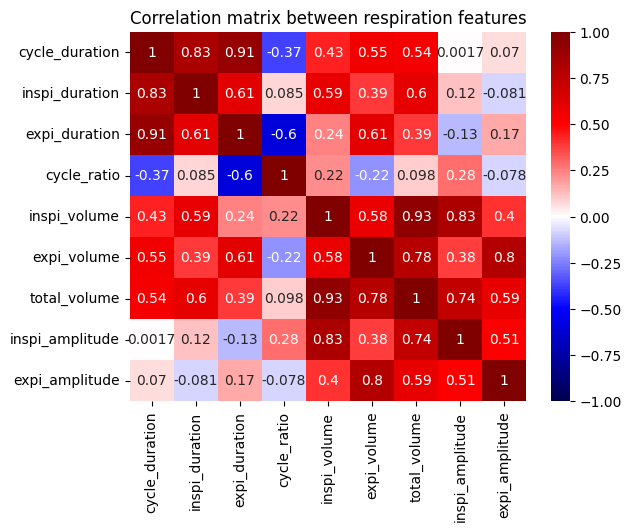

In [9]:
fig, ax = plt.subplots()
sns.heatmap(resp[metrics].corr('spearman',numeric_only = True), annot = True, vmin=-1, vmax= 1 , cmap = 'seismic', ax=ax)
ax.set_title('Correlation matrix between respiration features')
file = base_folder / 'Figures' / 'resp_features' / 'corr_matrix_resp_features.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

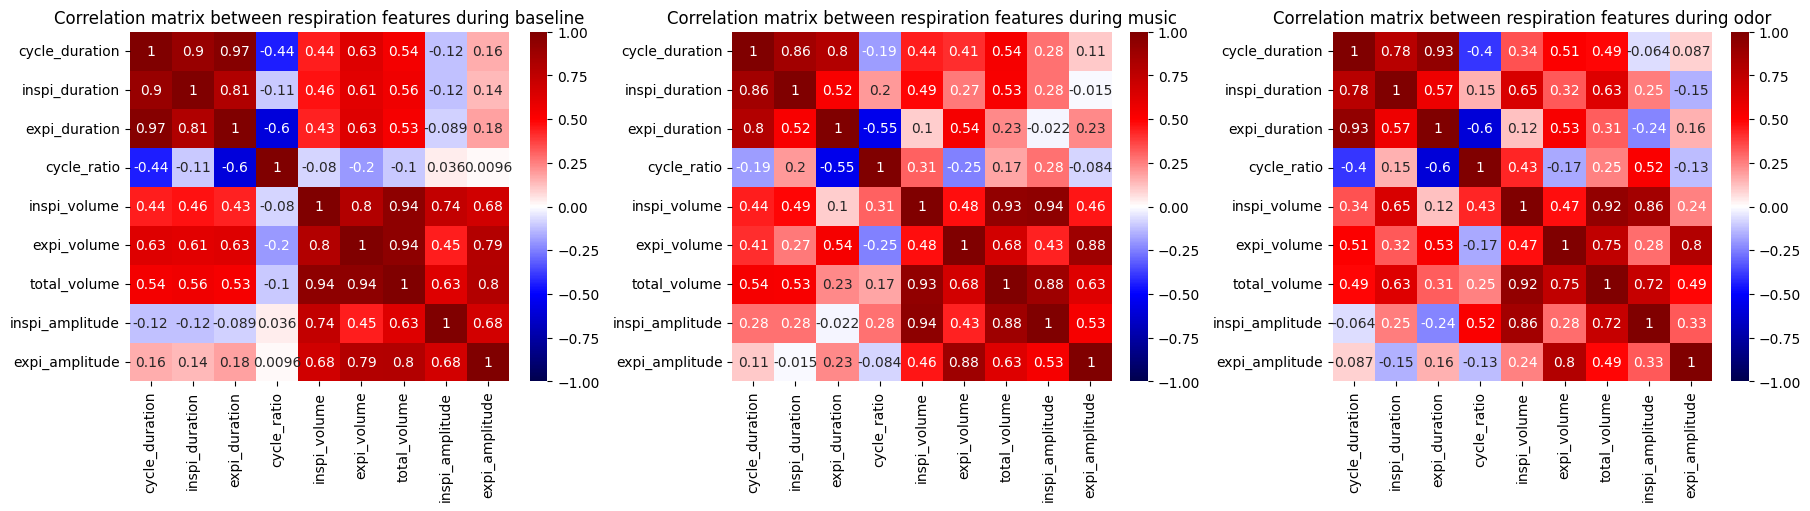

In [10]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), constrained_layout = True)

for c, ses in enumerate(session_keys):
    ax = axs[c]
    resp_ses = resp[resp['session'] == ses]
    sns.heatmap(resp_ses[metrics].corr('spearman',numeric_only = True), annot = True, vmin=-1, vmax= 1 , cmap = 'seismic', ax=ax)
    ax.set_title(f'Correlation matrix between respiration features during {ses}')
    
file = base_folder / 'Figures' / 'resp_features' / 'corr_matrix_resp_features_by_session.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

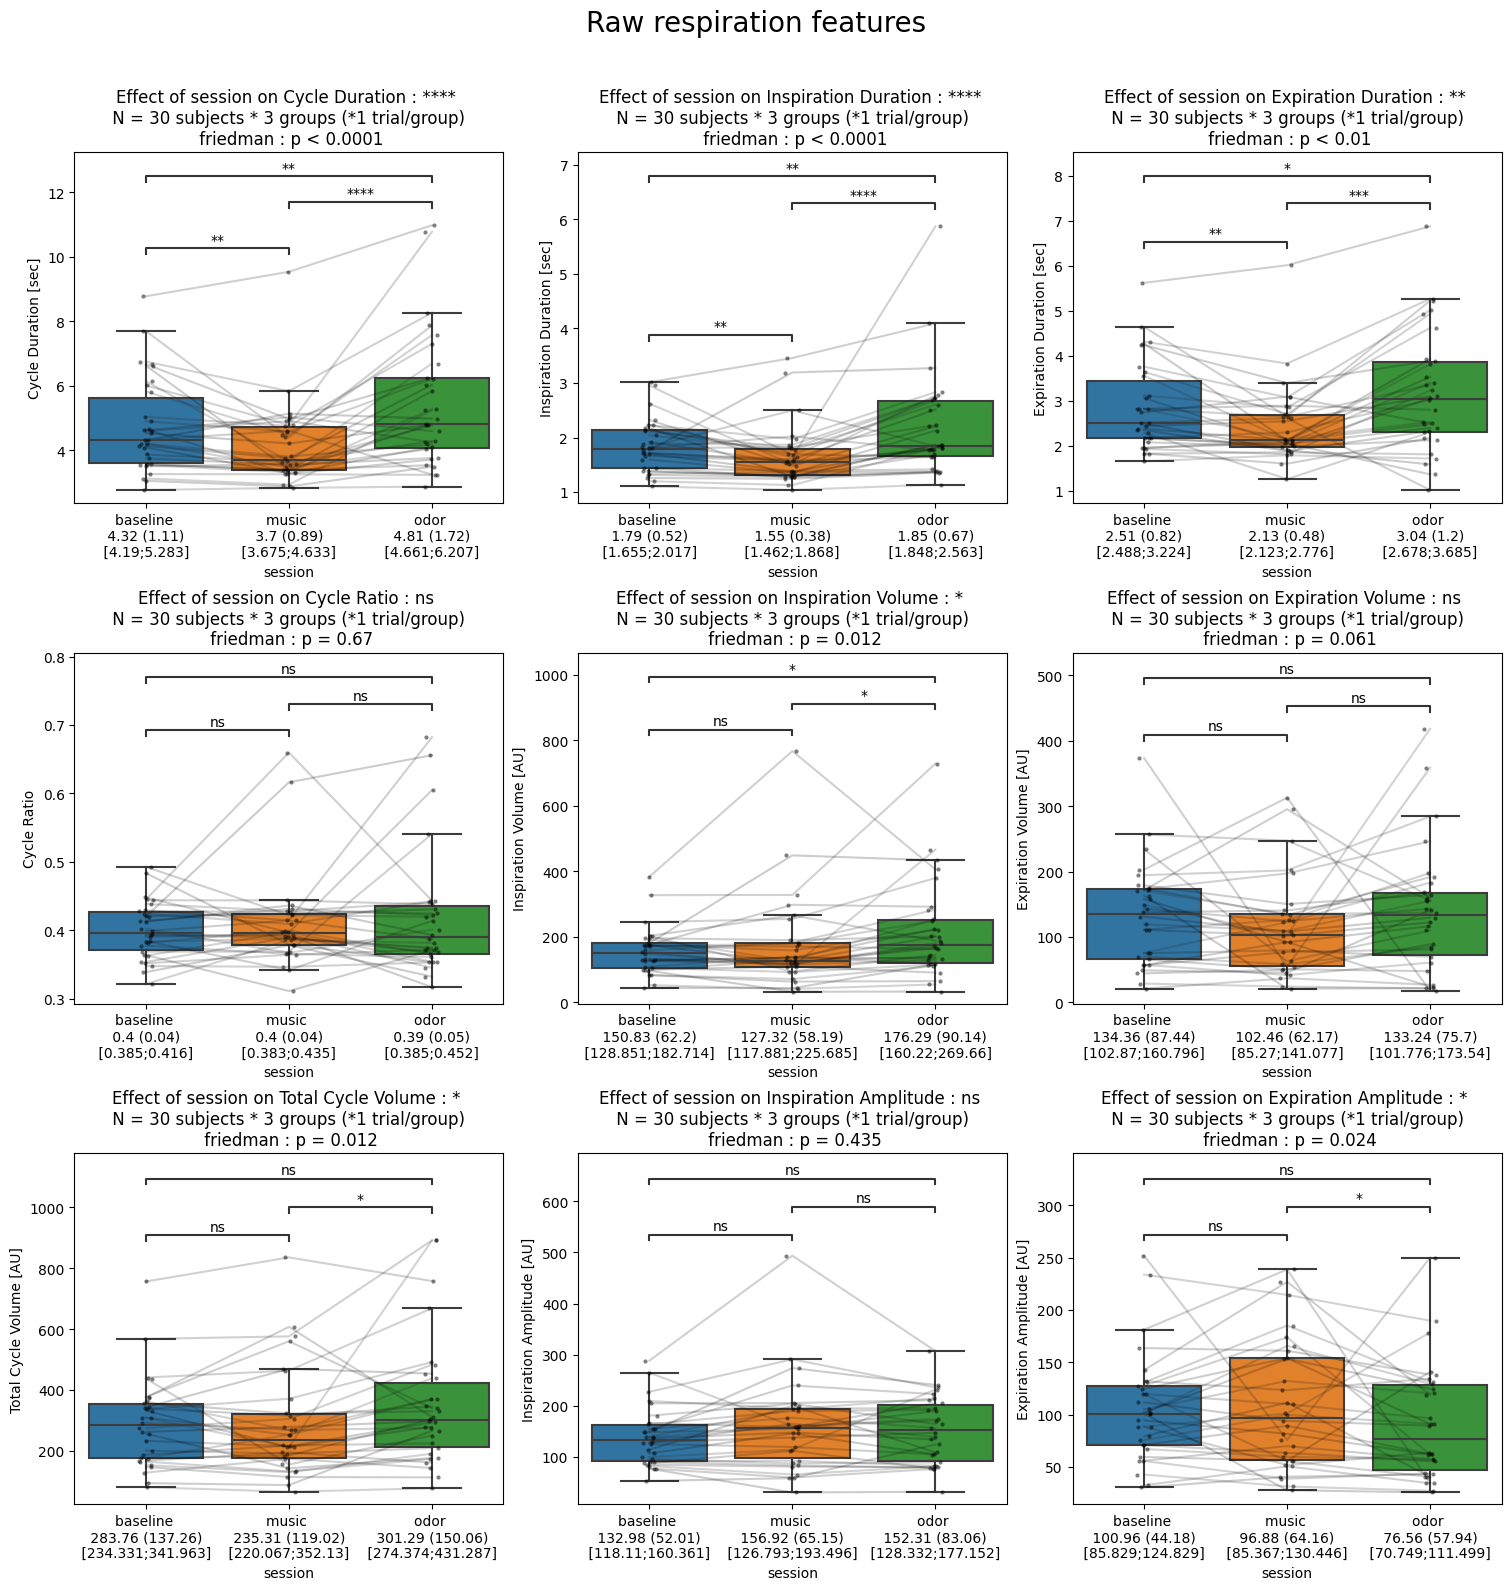

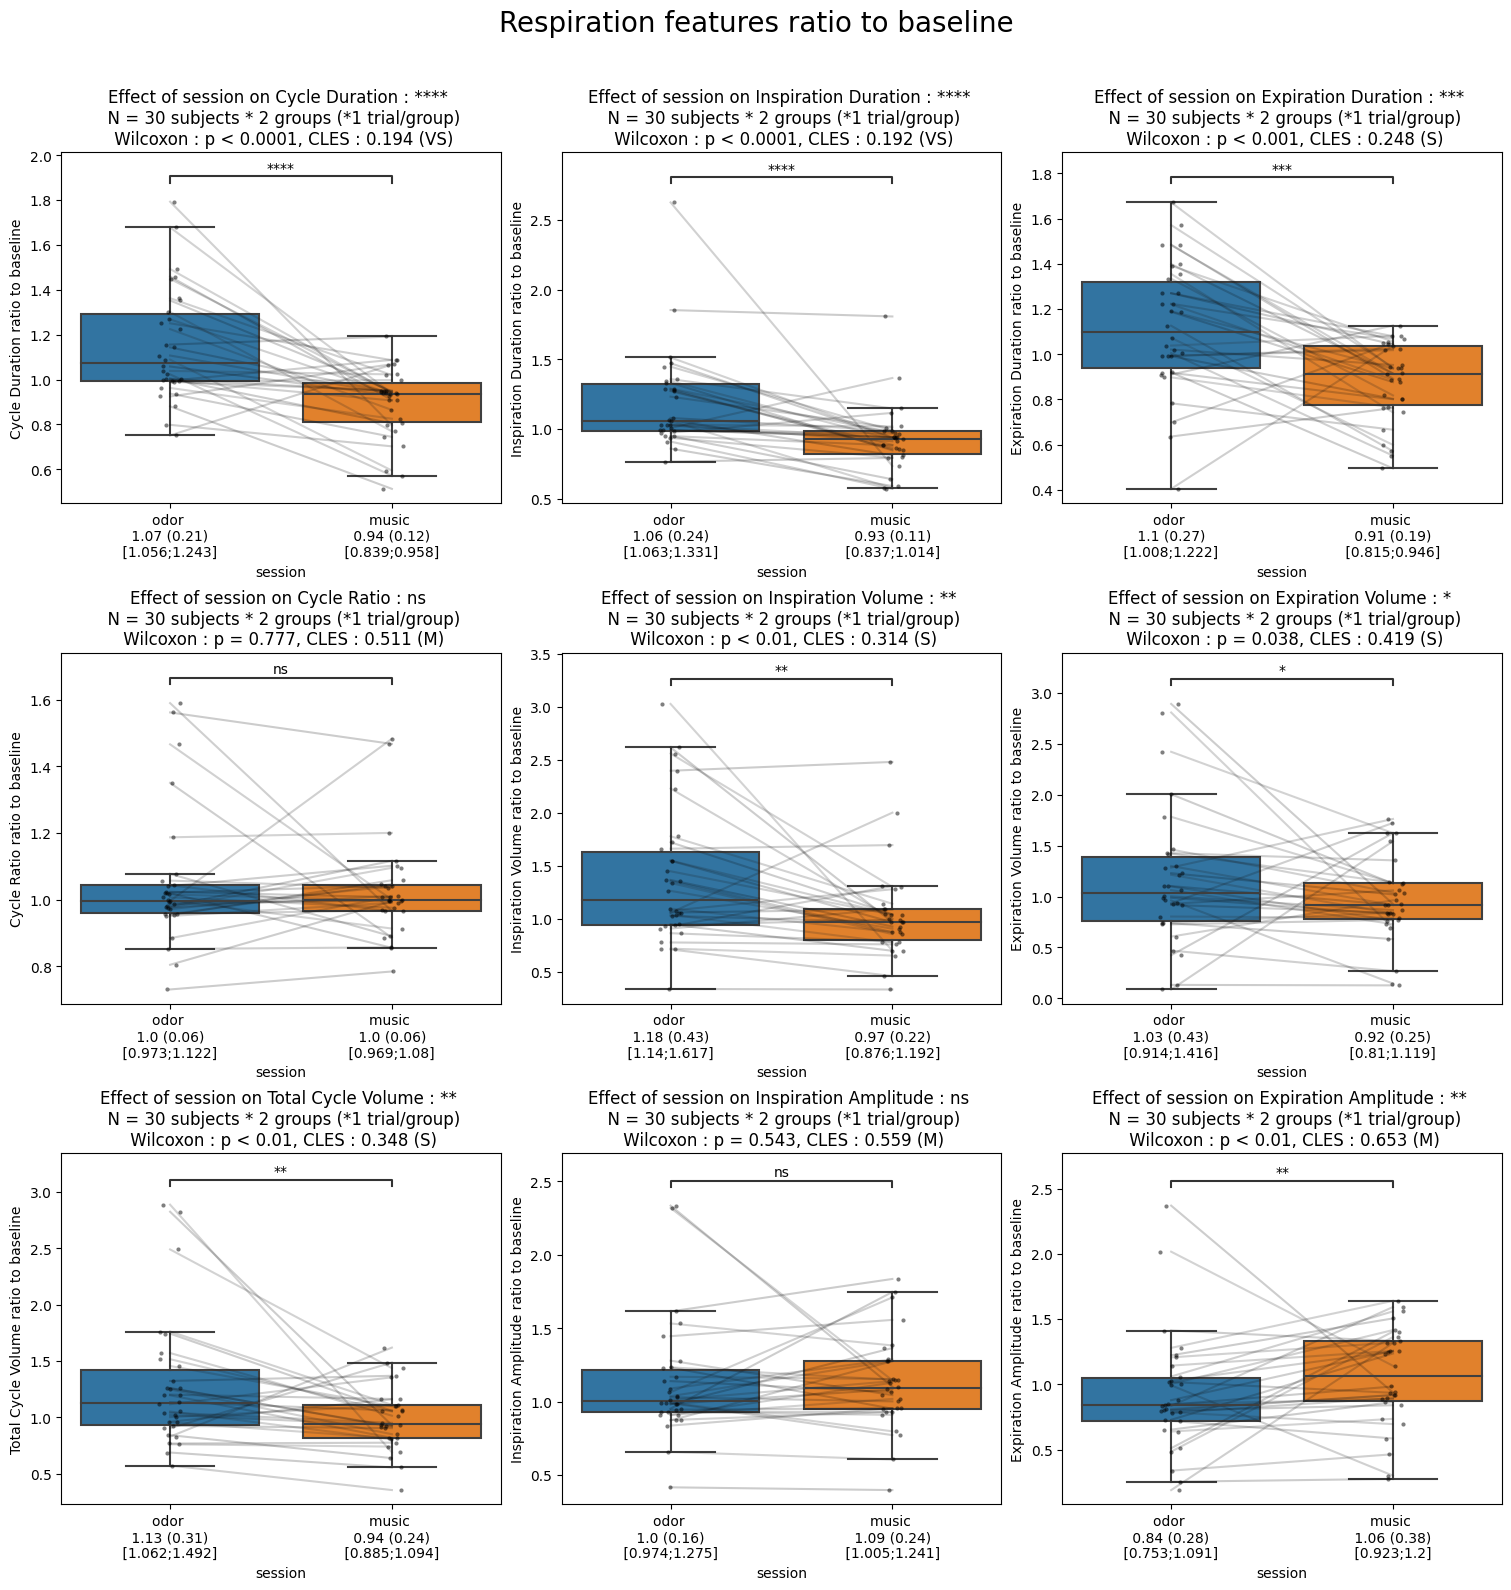

In [11]:
nrows = 3
ncols = 3
plot_metrics = np.array(metrics).reshape(nrows, ncols)

for suptitle, df in zip(['Raw respiration features','Respiration features ratio to baseline'],[resp, resp_baselined]):

    fig, axs = plt.subplots(nrows, ncols, figsize = (15,15), constrained_layout = True)
    fig.suptitle(suptitle, fontsize = 20, y = 1.05)

    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r,c]
            
            metric = plot_metrics[r,c]
            
            if suptitle == 'Respiration features ratio to baseline':
                outcome_unit = None
            else:
                outcome_unit = units[metric]
            
            gh.auto_stats(df = df, 
                          predictor = 'session', 
                          outcome = metric, 
                          design = 'within',
                          subject = 'participant', 
                          ax=ax,
                         outcome_clean_label = clean_labels[metric],
                         outcome_unit = units[metric])
            
            if suptitle == 'Respiration features ratio to baseline':
                ax.set_ylabel(f'{clean_labels[metric]} ratio to baseline')
                
    file = base_folder / 'Figures' / 'resp_features' / f'{suptitle}.png'
    fig.savefig(file, bbox_inches = 'tight')
    plt.show()